In [ ]:
# Code given
# import required libraries
!pip install wget
import os
import os.path

import matplotlib.pyplot as plt
import wget

import jax
import jax.numpy as jnp
import numpy.random as npr
from jax.api import jit, grad

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=fd40c1cc81f1ad9aefccf64c6a098bff48ec6683305584d8ab88f703072e6ee5
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
# Code given
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [ ]:
# Code given
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [ ]:
# Code given
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [ ]:
# Code given
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())

In [ ]:
# Code given
def dataFrameToArray(rating_df):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
    """
    matrix = np.zeros((rating_df.shape[0], 4), dtype=np.int32)
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[index, :] = jnp.array([userID, itemID, rating, timestamp])
    return matrix

big_array_raw = dataFrameToArray(rating_df)

big_array = jnp.vstack([big_array_raw[:, 0] - 1,
                           big_array_raw[:, 1] - 1,
                           big_array_raw[:, 2]]).T
# now it's zero-indexed

# Make train, validation, and test splits
train_mat = big_array[:80000, :]
valid_mat = big_array[80000:90000, :]
test_mat =  big_array[90000:100000, :]

train_inputs, train_targets = train_mat[:, :2], train_mat[:, 2].astype(jnp.float32)
test_inputs,  test_targets  = test_mat[:, :2],  test_mat[:, 2].astype(jnp.float32)



In [ ]:
train_inputs.shape
train_targets.shape

(80000,)

# **Recommender System**

**Haiyue Yang, Yun Shen, Xin Peng**


Most platforms we used nowadays, for example, Youtube, Amazon, Netflix, are supported by recommender systems. And it helps personalize the recommendations based on users' interest and browsing history, purchasing history. Netflix even has provided a Netflix Prize to honour teams that can make improvements on predicting users' ratings for movies. 

And in this report, we used MovieLens data sets colleted by the GroupLens Research Project. And it contains 100,000 ratings from 943 users on 1682 movies.

And we have explored the data, brainstormed what factors could help improve the recommender system, proposed several models, and implemented three variants of PMF below.

# Add-on Value of the Data

* Make recommendations for groups with similar interest: 
 * Imagine your view history and interest are similar to other people, you can be identified as a group and some group actions can be made to the whole group.

* Understand what’s trending over time for investment: 
 * Companies like Netflix will utilize this to decide what to produce for the next season.

* Suggest friends based on mutual interests: This can be implemented in social networks platforms.

* Show ads to target customers based on their view history

# Key Factors to Measure Success

* the number of daily active users: 
 * A streaming service with a sophisticated recommender system will attract users to stay active because they will be watching the recommended movies.

* the increase in the number of views for recommended movies: 
 * If the movies are recommended to the correct groups of people, there should be more people watching it.

* the rating of recommended movies by target users:
 * If the user likes the recommended movie, he tends to give a high rating.

* “not interested” reaction
 * One example is the like/dislike button on youtube.
 * If the user doesn’t like the recommended movie, it indicates that the recommender system goes wrong sometimes.



# Data Exploration


## Problems in the Data

In [ ]:
def getMovieData(folder_path, file_name):
    fields = ['itemID', 'itemTitle', 'releaseDate', 'videoReleaseDate', 'imdb', 'unknown', 'action', 'adventure', 'animation', 
              'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy',
              'film-noir', 'horror', 'musical', 'mystery', 'romance', 'sci-fi',
              'thriller', 'war', 'western']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='|', names=fields, encoding="ISO-8859-1")
    return data
movie_df = getMovieData(MOVIELENS_DIR, 'u.item')
movie_df = movie_df.drop(columns=['releaseDate', 'videoReleaseDate', 'imdb'])
rating_movie_df = pd.merge(rating_df, movie_df, on="itemID")

In [ ]:
cats = ['unknown', 'action', 'adventure', 'animation', 
              'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy',
              'film-noir', 'horror', 'musical', 'mystery', 'romance', 'sci-fi',
              'thriller', 'war', 'western']
counts = []
agg = rating_movie_df.agg('sum')
for cat in cats:
  counts.append(agg[cat])
category_df = pd.DataFrame({"category": cats, "count": counts})
category_df = category_df.sort_values('count')

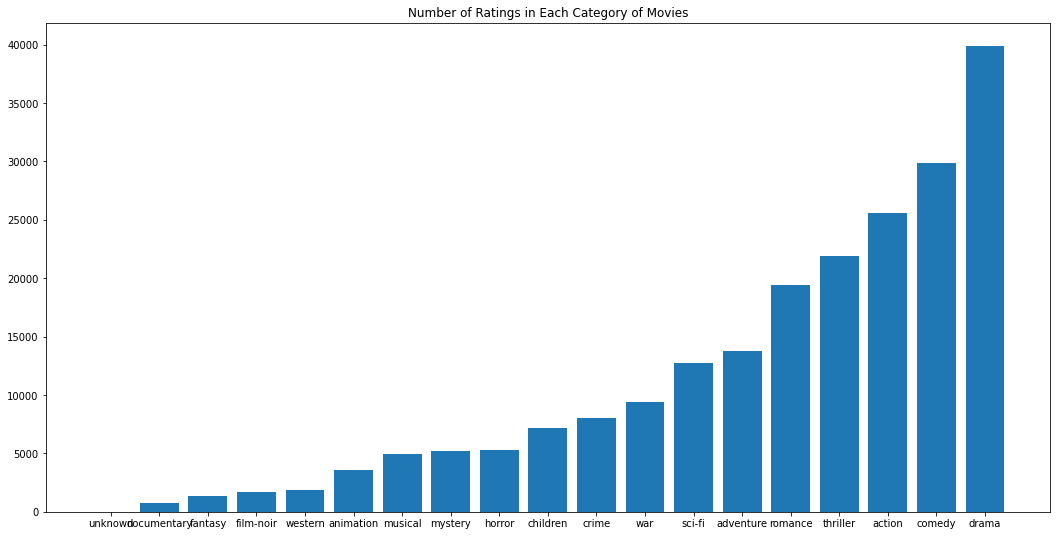

In [ ]:
plt.figure(figsize=(18,9))
plt.title("Number of Ratings in Each Category of Movies")
plt.bar(category_df['category'], category_df['count'])
plt.show()

* The number of ratings in each category varies a lot. 
* Some categories like action, comedy, drama, and thriller movies have more than 20 thousand ratings in total, but other categories like documentary movies have only fewer than 1000 ratings. 
* 10 ratings of movie do not have a known category.
* predictions based on the categorical information about the movies in unpopular categories or even in an unknown category might not be reliable.


## Distribution of Number of Ratings

In [ ]:
num_rating = rating_df[['userID', 'rating']].groupby(['userID']).agg('count')

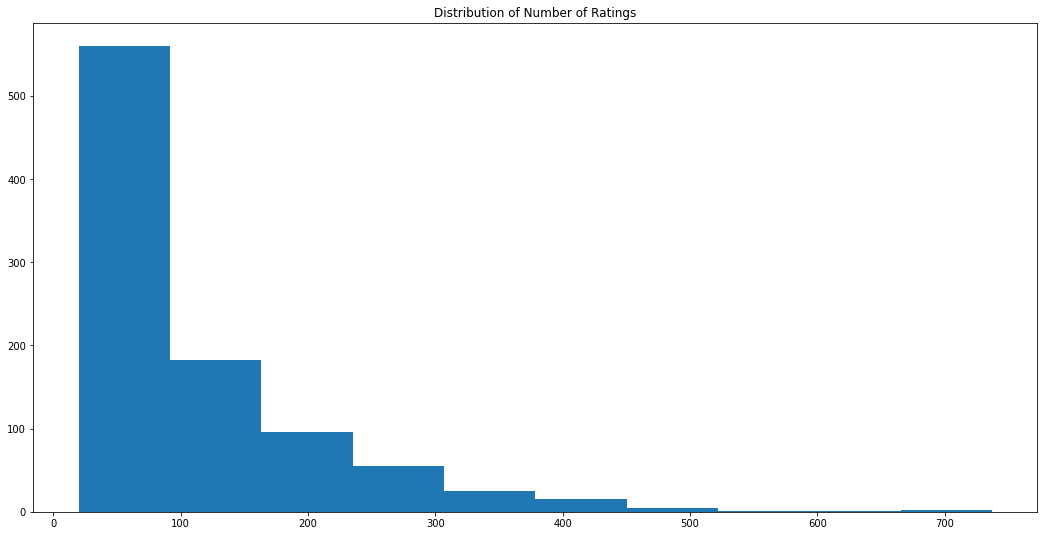

In [ ]:
plt.figure(figsize=(18,9))
plt.title("Distribution of Number of Ratings")
plt.hist(num_rating['rating'], bins = 10) 
plt.show()

* Number of ratings of each user ranges from 20 to approximately 800. 
* Ghost users with fewer than 20 ratings were already deleted.
* The distribution of unimodal and strongly skewed to the right
* More than half of users having fewer than 100 ratings and few users having more than 300 ratings.


## Distribution of Ratings

In [ ]:
rating = rating_df[['userID', 'rating']].groupby('rating').agg(['count'])

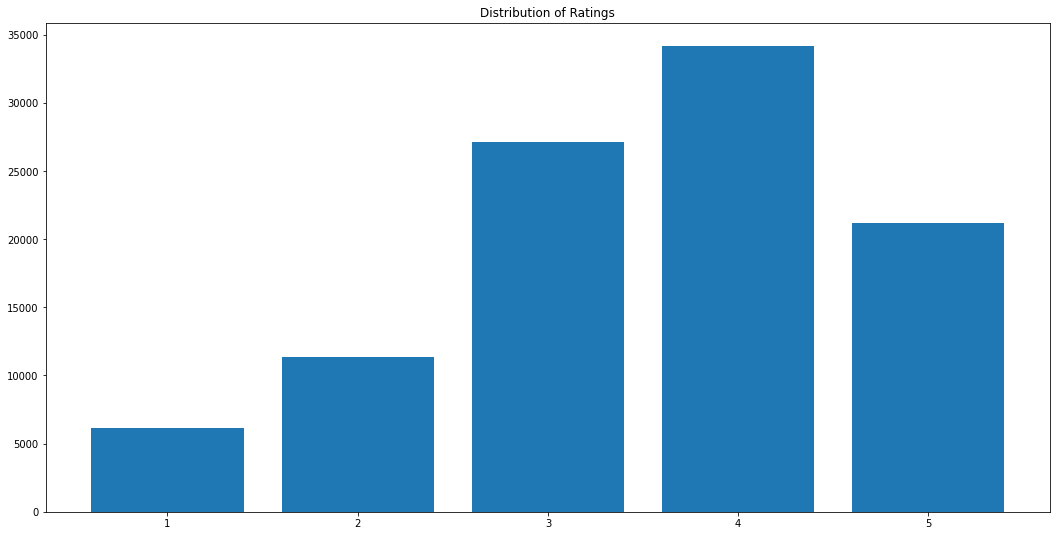

In [ ]:
plt.figure(figsize=(18,9))
plt.title('Distribution of Ratings')
plt.bar(rating['userID'].index, rating['userID']['count'])
plt.show()

* The distribution of ratings is uni-model and skewed to the left, with a peak at a rating of 4. 
* Most of the ratings have a score of 4 or 3, a few ratings have a score of 5, and only a small proportion of ratings have a score of 1 or 2.
* Fake users with all-5 or all all-1 ratings were already deleted.

## Things Depend on Time

* Movies are merging.
* Users' preference change with time.
* Users' rating standard on movies change with time.
* Hot topics and movie trend change over time.


# Complementary Sources of Data
The data we used here only contain title, release date, video release date, IMDB URL, genres about the movies, but additional information about movies like 

*   movie contents
*   cast
*   awards
*   professional ratings
*   popularity
*   language

can be very useful in helping make better recommendation.

Similarly, since our data only has age, gender, occupation, zip code about users, some complementary sources can be users' favourite directors, living country, spoken language, etc.

In addition, users' search history and browsing history may also be useful in showing what they are interested in.

# List of Factors that Could Affect the Recorded Data
Before building up a model, it is important to notice that rating in reality is very complicated, and there are many factors that could conceivably influence people's rating. Here are some of these factors:

*   The overall rating and professional rating of the movie.
*   Preference over some actor/actress in a movie.
*   People's rating habits are different. Some give an overall high rating; some people tend to give low ratings.
*   Popularity of the movie.
*   Availability of the movie. People have easy access to some movies, while others are not.
*   Social influence and reputation of the movies.
*   Personal relevance to the movie.
*   Culture similarity with the movie.
*   The user's account being hacked.
*   Some users are bots, and give fake ratings.
*   Standard of 'high quality movies' has changed over time. For example, the IMAX-3D techonology in 2009 is very rare and new, movies like Avatar using IMAX-3D techonology received high ratings. But people are no longer feel so impressed by IMAX-3D techonology in 2021.
*   Viewing condition of the user. Viewing a movie in computer and in cinema will have different visual effect and sound effect.
*   Users' mood when watching a movie.
*   Movie's relevance to the hot topics. For example, movie Flu shot in 2013 received higher ratings in 2020 than it was in 2013, since it is closely related to COVID-19.


# Model Staircase
Here are some models we proposed.

*   Use mean rating of the movies rated by each user assuming each user will give same rating to all movies.
*   Use KNN to predict movie rating by finding the Nearest Neighbours that the user has rated.
*   Use different user and movie latents for female and male.
*   Use movie side info instead of movie latents.
(This does not predict well, and the final testing rmse is around 0.78. So only use movie side info, i.e., 19 genres is not enough here.)
*   Add temporal features to the PMF. (Variant 1: Temporal)
*   Use side info in addition to latents. (Variant 2: Side Info)
*   Prediction function is a non-linear matrix factorization. (Variant 3: Non-linear)


# Baseline Model (PMF)


The baseline model provided for us uses PMF. 

$r_{ui} = P_uQ_i^T$, 

where $r_{ui}$ is the rating of User $u$ to Item $i$, and $P$ is user latent factor matrix with dimension $n \times k$, $Q$ is item latent factor matrix with dimension $m \times k$.

And we will implement three variants of PMF below.


In [ ]:
# Model implementation in JAX (https://github.com/google/jax)
from jax.scipy.special import logsumexp

# Optimization hyperparameters
step_size = 10.0
train_iters = 5000
iterations = []
train_loss_lst = []
train_rmse_lst = []
test_rmse_lst = []

# Model hyperparameters
num_factors = 1
init_scale = 0.1
latent_param_regularization = 0.1

# Init parameters.  Add an extra column for biases.
np.random.seed(2)
user_latents  = np.random.randn(num_users, num_factors + 1) * init_scale
movie_latents = np.random.randn(num_items, num_factors + 1) * init_scale
params = (user_latents, movie_latents)

# Actual model
mean_rating = jnp.mean(train_targets)
def pmf_predict(user_latents, movie_latents, inputs):
  (user_index, movie_index) = (inputs[:, 0], inputs[:, 1])
  raw_preds = jnp.sum(user_latents[user_index, :-1] * movie_latents[movie_index, :-1], axis=1) \
         + mean_rating + user_latents[user_index, -1] + movie_latents[movie_index,-1]
  return raw_preds

def regularization_loss(user_latents, movie_latents):
  return latent_param_regularization * (jnp.mean((user_latents)**2) + jnp.mean((movie_latents)**2))

def prediction_mse(params, inputs, targets):
  preds = pmf_predict(*params, inputs)
  return (preds - targets)**2

def training_loss(params, inputs, targets):
  return regularization_loss(*params) + jnp.mean(prediction_mse(params, inputs, targets), axis=0)

# One training step
@jit  # Pre-compiles the function to speed up training.
def sgd_update(params, i):  # Stochastic gradient descent
  (grads_user, grads_movie) = grad(training_loss)(params, train_inputs, train_targets)
  (user_latents, movie_latents) = params
  return (user_latents  - step_size * grads_user,  # one step of gradient descent
          movie_latents - step_size * grads_movie)

# Main training loop
for i in range(train_iters):
  params = sgd_update(params, i)
  if i % 100 == 0:
    # Print current progress
    train_loss = training_loss(params, train_inputs, train_targets)
    train_rmse = jnp.sqrt(prediction_mse(params, train_inputs, train_targets))
    test_rmse  = jnp.sqrt(prediction_mse(params, test_inputs, test_targets))
    print(i, train_loss, jnp.mean(train_rmse), jnp.mean(test_rmse))
    iterations.append(i)
    train_loss_lst.append(train_loss)
    train_rmse_lst.append(jnp.mean(train_rmse))
    test_rmse_lst.append(jnp.mean(test_rmse))

0 1.2531517 0.9336393 0.9329738
100 0.8892034 0.74361056 0.7620929
200 0.8677213 0.7312353 0.75058323
300 0.8594228 0.7260171 0.74692917
400 0.8529516 0.7220692 0.7453697
500 0.84596014 0.7179627 0.7446068
600 0.8390362 0.7137949 0.74394524
700 0.8327416 0.7099089 0.7429101
800 0.82677925 0.70623785 0.74132067
900 0.82080483 0.7026735 0.7392549
1000 0.81487006 0.6991699 0.73682266
1100 0.8094192 0.69590694 0.7344423
1200 0.80489284 0.6931623 0.7324936
1300 0.80141115 0.69096863 0.73103917
1400 0.79883486 0.6892813 0.7299567
1500 0.7969499 0.6879813 0.7291591
1600 0.79556614 0.6869843 0.72858745
1700 0.79454064 0.6862012 0.7281751
1800 0.7937722 0.6855745 0.7278624
1900 0.7931895 0.68507075 0.7276199
2000 0.7927428 0.68466854 0.7274495
2100 0.7923968 0.6843394 0.7273101
2200 0.79212606 0.68406534 0.7272029
2300 0.7919122 0.68383664 0.7271173
2400 0.79174185 0.6836432 0.7270539
2500 0.7916051 0.6834785 0.72700113
2600 0.7914945 0.683336 0.7269562
2700 0.7914044 0.6832125 0.7269146
2800 0

# Variant 1: Adding Temporal Features to PMF

In reality, user preference and movie popularity change over time. Therefore, we should account for the temporal effects reflecting the dynamic nature of user-item interactions. To accomplish this, we can add a temporal term that affects user preferences and, therefore, the interaction between users and items.

Recall our original PMF uses the latent of each user and the latent of each movie. We now add temporal latent accounting for the change in time and the user-temporal latent accounting for the change of user reaction over time. Thus, the user-time interaction is a dot product between the user temporal latent and the temporal latent.

$r_{ui} = P_uQ_i^T + P_u(t)$, 

where $r_{ui}$ is the rating of User $u$ to Item $i$, and $P$ is user latent factor matrix with dimension $n \times k$, $Q$ is item latent factor matrix with dimension $m \times k$ (the same as the baseline PMF), and $P_u (t)$ takes user factors as a function of time.

## Model and Sanity Check

In [ ]:
# Add a new column "numRate" to measure the number of times each user posts a rating; refer as rank
rating_rank_df = rating_df.copy()
rating_rank_df['numRate'] = rating_rank_df.groupby("userID")["timestamp"].rank(ascending=True)

In [ ]:
# A new dataframe to array function that also includes the new column rank; adapted from the original one
def dataFrameToArrayWithRank(rating_rank_df):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
    """
    matrix = np.zeros((rating_rank_df.shape[0], 5), dtype=np.int32)
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp, numRate) in rating_rank_df.itertuples():
        matrix[index, :] = np.array([userID, itemID, rating, timestamp, numRate])
    return matrix

rank_big_array = dataFrameToArrayWithRank(rating_rank_df)

# Make train, validation, and test splits
rank_train_mat = rank_big_array[:80000, :]
rank_valid_mat = rank_big_array[80000:90000, :]
rank_test_mat =  rank_big_array[90000:100000, :]

rank_train_inputs, rank_train_targets = rank_train_mat[:, [0,1,4]], rank_train_mat[:, 2].astype(jnp.float32)
rank_test_inputs,  rank_test_targets  = rank_test_mat[:, [0,1,4]], rank_test_mat[:, 2].astype(jnp.float32)



In [ ]:
# Save these constants to generate latents
num_users = len(rating_rank_df.userID.unique())
num_items = len(rating_rank_df.itemID.unique())
num_rate = len(rating_rank_df.numRate.unique())

Number of iterations, training loss, training RMSE, testing RMSE using Variant 1.

In [ ]:
# Model implementation in JAX (https://github.com/google/jax)

# Optimization hyperparameters
step_size = 10.0
train_iters = 5000
train_loss_lst3 = []
train_rmse_lst3 = []
test_rmse_lst3 = []

# Model hyperparameters
num_factors = 3
init_scale = 0.1
latent_param_regularization = 0.1
kt = 2 # Number of dimensions per temporal

# Init parameters
user_latents  = np.random.randn(num_users, num_factors) * init_scale
movie_latents = np.random.randn(num_items, num_factors) * init_scale
temp = np.random.rand(num_rate, kt) * init_scale # Temporal latent
user_temp = np.random.rand(num_users, kt) * init_scale # User-Temporal latent
params = (user_latents, movie_latents, temp, user_temp)

# Actual model
mean_rating = jnp.mean(rank_train_targets)
def pmf_predict(user_latents, movie_latents, temp, user_temp, inputs):
  (user_index, movie_index, rank) = (inputs[:, 0], inputs[:, 1], inputs[:, 2])
  return jnp.sum(user_latents[user_index] * movie_latents[movie_index], axis=1) + jnp.sum(temp[rank] * user_temp[user_index], axis=1) + mean_rating

def regularization_loss(user_latents, movie_latents, temp, user_temp, inputs):
  return latent_param_regularization * (jnp.mean(user_latents**2) + jnp.mean(movie_latents**2) + jnp.mean(temp**2) + jnp.mean(user_temp**2))

def prediction_mse(params, inputs, targets):
  preds = pmf_predict(*params, inputs)
  return (preds - targets)**2

def training_loss(params, inputs, targets):
  return regularization_loss(*params, inputs) + jnp.mean(prediction_mse(params, inputs, targets), axis=0)

# One training step
@jit  # Pre-compiles the function to speed up training.
def sgd_update(params, i):  # Stochastic gradient descent
  (grads_user, grads_movie, grad_temp, grad_user_temp) = grad(training_loss)(params, rank_train_inputs, rank_train_targets)
  (user_latents, movie_latents, temp, user_temp) = params
  return (user_latents  - step_size * grads_user,  # one step of gradient descent
          movie_latents - step_size * grads_movie, 
          temp - step_size * grad_temp, 
          user_temp - step_size * grad_user_temp)

# Main training loop
for i in range(train_iters):
  params = sgd_update(params, i)
  if i % 100 == 0:
    # Print current progress
    train_loss = training_loss(params, rank_train_inputs, rank_train_targets)
    train_rmse = jnp.sqrt(prediction_mse(params, rank_train_inputs, rank_train_targets))
    test_rmse  = jnp.sqrt(prediction_mse(params, rank_test_inputs, rank_test_targets))
    print(i, train_loss, jnp.mean(train_rmse), jnp.mean(test_rmse))
    # Save the results for plotting purpose
    train_loss_lst3.append(train_loss)
    train_rmse_lst3.append(jnp.mean(train_rmse))
    test_rmse_lst3.append(jnp.mean(test_rmse))

0 1.2738314 0.945103 0.94745064
100 1.1786982 0.90387565 0.92231274
200 1.0713224 0.83177096 0.8629265
300 0.95032704 0.7677249 0.8097566
400 0.8670451 0.72243065 0.77153456
500 0.8200652 0.69554865 0.75337356
600 0.7926598 0.6790036 0.7440422
700 0.7759146 0.668286 0.73918927
800 0.7649982 0.66105455 0.73678064
900 0.7574419 0.65586495 0.73544556
1000 0.7519443 0.65195405 0.73470646
1100 0.74778193 0.6488961 0.73430705
1200 0.74453 0.6464574 0.73417723
1300 0.7419253 0.6444637 0.7341016
1400 0.7397969 0.64279395 0.7340288
1500 0.73802876 0.64136523 0.73393106
1600 0.7365397 0.64013547 0.73384213
1700 0.73527044 0.63907266 0.7337596
1800 0.73417723 0.63814235 0.73367184
1900 0.7332268 0.6373211 0.7335686
2000 0.7323937 0.6365943 0.7334614
2100 0.7316577 0.6359492 0.73334694
2200 0.7310028 0.6353814 0.7332312
2300 0.7304165 0.63487965 0.7330947
2400 0.72988844 0.63443 0.73293805
2500 0.7294104 0.6340248 0.7327798
2600 0.7289755 0.63365513 0.73261666
2700 0.72857815 0.6333141 0.7324604
2

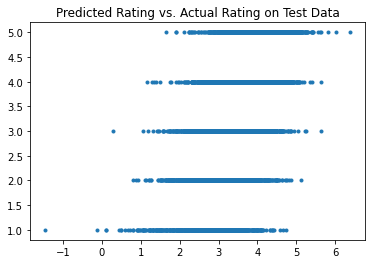

In [ ]:
plt.plot(pmf_predict(*params, rank_test_inputs), rank_test_mat[:, 2].astype(jnp.float32), '.')
plt.title("Predicted Rating vs. Actual Rating on Test Data")
plt.show()

From the plot of predicted rating vs. actual rating on test data above, we can see a trend that the range of predicted ratings shifts to the right as the actual rating increases from 1 to 5, indicating that our prediction model follows the correct trend and functions reasonably in predicting users' ratings to the movies. However, the variance in predictions seems to be very large, and we want to investigate further to find out the possible reasons why such large variance exists.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
# MSE of each observation of the testing data
test_rank_mse = prediction_mse(params, rank_test_inputs, rank_test_targets)
test_rank_df = rating_rank_df.iloc[90000:, :]
test_rank_df['mse'] = test_rank_mse.tolist()

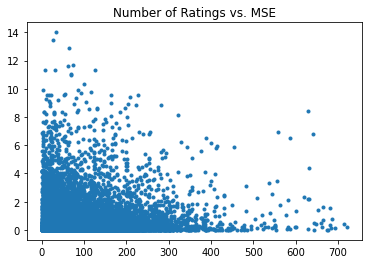

In [ ]:
plt.plot(test_rank_df['numRate'], test_rank_df['mse'], '.')
plt.title("Number of Ratings vs. MSE")
plt.show()

One possible reason for such large variances is that the predicting power of users with less rating history is significantly weaker that that of users with numerous rating histories. Thus, we calcuate the prediction MSE for each user, and we plot the number of ratings vs. MSE.

From the plot above, we see that the variance in MSE decreases as the number of ratings by the user increases. This correponsds to our previous assumption that the prediction for users with many rating histories is more accurate.


In [ ]:
test_rank_df['numRate'].describe()

count    10000.000000
mean        95.457200
std         92.991796
min          1.000000
25%         27.000000
50%         66.500000
75%        136.000000
max        720.000000
Name: numRate, dtype: float64

Table I: The Summary of the Number of Ratings

In [ ]:
first_q = test_rank_df[test_rank_df['numRate'].astype(jnp.float32) <= 27]
first_q['mse'].describe()

count    2.521000e+03
mean     9.176382e-01
std      1.398241e+00
min      2.698476e-08
25%      8.740047e-02
50%      3.904262e-01
75%      1.096429e+00
max      1.344413e+01
Name: mse, dtype: float64

Table II: The MSE Summary for Users in 1st Quantile in Terms of the Number of Ratings

In [ ]:
fourth_q = test_rank_df[test_rank_df['numRate'].astype(jnp.float32) >= 136]
fourth_q['mse'].describe()

count    2.515000e+03
mean     8.390989e-01
std      1.349318e+00
min      4.800773e-08
25%      7.149035e-02
50%      3.197210e-01
75%      9.899696e-01
max      9.570035e+00
Name: mse, dtype: float64

Table III: The MSE Summary for Users in 4th Quantile in Terms of the Number of Ratings

We want to look at the numbers more closely. The average MSE of predictions among users who are in the first quantile in terms of the number of ratings is around 0.9228. The average MSE of predictions among users who are in the first quantile in terms of the number of ratings is around 0.8143. This is an indication to our previous assumption.

## Result and Limitation

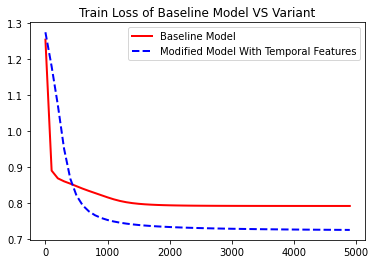

In [ ]:
plt.plot(iterations, train_loss_lst, marker='', color='red', linewidth=2, label="Baseline Model")
plt.plot(iterations, train_loss_lst3, marker='', color='blue', linewidth=2, linestyle='dashed', label="Modified Model With Temporal Features")
plt.title("Train Loss of Baseline Model VS Variant")
plt.legend()
plt.show()

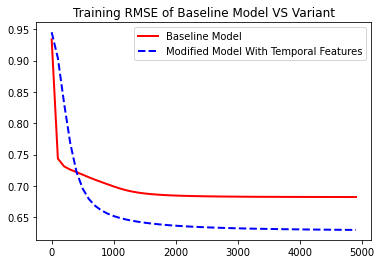

In [ ]:
plt.plot(iterations, train_rmse_lst, marker='', color='red', linewidth=2, label="Baseline Model")
plt.plot(iterations, train_rmse_lst3, marker='', color='blue', linewidth=2, linestyle='dashed', label="Modified Model With Temporal Features")
plt.title("Training RMSE of Baseline Model VS Variant")
plt.legend()
plt.show()

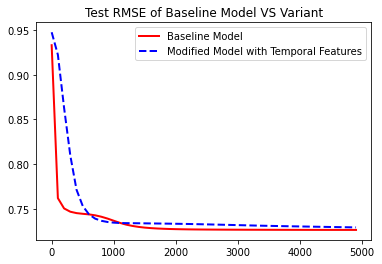

In [ ]:
plt.plot(iterations, test_rmse_lst, marker='', color='red', linewidth=2, label="Baseline Model")
plt.plot(iterations, test_rmse_lst3, marker='', color='blue', linewidth=2, linestyle='dashed', label="Modified Model with Temporal Features")
plt.title("Test RMSE of Baseline Model VS Variant")
plt.legend()
plt.show()

From the above three plots, we can see that our variant has lowered training loss by 8.71%, and training RMSE by 7.78%. The test RMSE is still slightly higher than the baseline model at the 5000th iteration, but it seems to decrease faster than the baseline model and we can believe that it will at least perform as the same as the baseline model with more iterations. 

Since we are using a Stochastic gradient descent to train our model, we can believe that our model reaches the maximum level with appropriate hyperparameters. To improve this model specifically, we might need to incorporate other models, such as other user demographics.

# Variant 2: Using Side Info in Addition to Latents.

In the baseline model, both the user latent and the movie latent has two columns, one representing the latent factor and the other representing the bias for the mean. However, a user's preference can vary in movies genres, so the user latent for different movie genres can be different. Therefore, in this model, we add side info for movie genres as a variant to the baseline model.

In this variant, while the movie latent remains to be a $(2 \times n)$ matrix as in the baseline model, we now define the user latent as a $(k+1 \times n)$ matrix, where $k$ is the number of genres and $n$ is the number of users. Then, we also define a matrix indicate the genres that a movies belong to.

The baseline model predicts the rating based on the movie latent and the user latent in general, and based on the two new matrices we designed, the variant model predicts the rating based on the movie latent and the user latent for the specific genres of the movie.

## Model and Sanity Check

In [ ]:
movie_cat = movie_df.drop(columns = ['itemID', 'itemTitle'])
movie_cat = movie_cat.values

Number of iterations, training loss, training RMSE, testing RMSE using Variant 2.

In [ ]:
# Model implementation in JAX (https://github.com/google/jax)
from jax.scipy.special import logsumexp

# Optimization hyperparameters
step_size = 10.0
train_iters = 5000
iterations = []
train_loss_lst1 = []
train_rmse_lst1 = []
test_rmse_lst1 = []

# Model hyperparameters
num_factors = 1
num_cats = len(cats)
init_scale = 0.1
latent_param_regularization = 0.1

# Init parameters.  Add an extra column for biases.
np.random.seed(2)
user_latents  = np.random.randn(num_users, num_cats + 1) * init_scale
movie_latents = np.random.randn(num_items, num_factors + 1) * init_scale
params = (user_latents, movie_latents)

# Actual model
mean_rating = jnp.mean(train_targets)
def pmf_predict(user_latents, movie_latents, inputs):
  (user_index, movie_index) = (inputs[:, 0], inputs[:, 1])
  item_cat = jax.device_put(movie_cat)[movie_index, :]
  item_latent = jnp.sum(item_cat * user_latents[user_index, :-1], axis=1)
  item_latent = item_latent.reshape((item_latent.shape[0], 1))
  raw_preds = jnp.sum(item_latent * movie_latents[movie_index, :-1], axis=1) \
         + mean_rating + user_latents[user_index, -1] + movie_latents[movie_index,-1]
  return raw_preds

def regularization_loss(user_latents, movie_latents):
  return latent_param_regularization * (jnp.mean((user_latents)**2) + jnp.mean((movie_latents)**2))

def prediction_mse(params, inputs, targets):
  preds = pmf_predict(*params, inputs)
  return (preds - targets)**2

def training_loss(params, inputs, targets):
  return regularization_loss(*params) + jnp.mean(prediction_mse(params, inputs, targets), axis=0)

# One training step
@jit  # Pre-compiles the function to speed up training.
def sgd_update(params, i):  # Stochastic gradient descent
  (grads_user, grads_movie) = grad(training_loss)(params, train_inputs, train_targets)
  (user_latents, movie_latents) = params
  return (user_latents  - step_size * grads_user,  # one step of gradient descent
          movie_latents - step_size * grads_movie)

# Main training loop
for i in range(train_iters):
  params = sgd_update(params, i)
  if i % 100 == 0:
    # Print current progress
    train_loss = training_loss(params, train_inputs, train_targets)
    train_rmse = jnp.sqrt(prediction_mse(params, train_inputs, train_targets))
    test_rmse  = jnp.sqrt(prediction_mse(params, test_inputs, test_targets))
    print(i, train_loss, jnp.mean(train_rmse), jnp.mean(test_rmse))
    iterations.append(i)
    train_loss_lst1.append(train_loss)
    train_rmse_lst1.append(jnp.mean(train_rmse))
    test_rmse_lst1.append(jnp.mean(test_rmse))

0 1.2498736 0.9289224 0.9326297
100 0.8847966 0.74276423 0.7610215
200 0.8600893 0.7295312 0.7495494
300 0.84720314 0.7225242 0.7461157
400 0.8317387 0.71436924 0.7450587
500 0.8127456 0.70421106 0.74516636
600 0.7946565 0.6941138 0.74560666
700 0.77919996 0.6851901 0.74668473
800 0.76616544 0.6775161 0.7485301
900 0.7550875 0.6709756 0.7507244
1000 0.74567044 0.66531503 0.75286776
1100 0.7376694 0.66041386 0.75505626
1200 0.73084813 0.65615135 0.75722015
1300 0.7249889 0.6524085 0.7592253
1400 0.7199077 0.6491157 0.7610682
1500 0.7154621 0.64623016 0.76281106
1600 0.7115494 0.643664 0.76442295
1700 0.7080947 0.64136153 0.76601696
1800 0.7050393 0.63931453 0.7674964
1900 0.7023325 0.6374722 0.76884866
2000 0.69992745 0.6358149 0.7701266
2100 0.69778097 0.63431895 0.77133673
2200 0.6958541 0.6329705 0.7724469
2300 0.6941139 0.63173604 0.77348214
2400 0.6925325 0.6305969 0.77442515
2500 0.6910877 0.62956333 0.7752891
2600 0.6897611 0.62861353 0.77605873
2700 0.6885372 0.6277328 0.7767790

In [ ]:
import warnings
warnings.filterwarnings('ignore')
# MSE of each observation of the testing data
test_mse = prediction_mse(params, test_inputs, test_targets)
test_rating_df = rating_df.iloc[90000:, :]
test_df = pd.merge(test_rating_df, movie_df, on="itemID")
test_df['mse'] = test_mse.tolist()

In [ ]:
category_df.describe()

,count
count,19.000000
mean,11189.210526
std,11236.960723
min,10.000000
25%,2729.500000
50%,7182.000000
75%,16607.000000
max,39895.000000


*Table 1:* The 1st quantile of the number of ratings in each category is 2729.5. And the 3rd qunatile is 16607.

In [ ]:
cat_fewer = category_df[category_df['count'] < 2729.5]['category'].tolist()
test_df_fewer = test_df[np.sum(test_df[cat_fewer], axis = 1)!=0]
test_df_fewer['mse'].describe()

count    5.340000e+02
mean     1.059674e+00
std      1.896921e+00
min      2.595908e-07
25%      8.927642e-02
50%      4.083659e-01
75%      1.249443e+00
max      2.114978e+01
Name: mse, dtype: float64

*Table 2:* The average MSE of ratings in unpopular categories is 1.059674

In [ ]:
cat_more = category_df[category_df['count'] > 16607]['category'].tolist()
test_df_more = test_df[np.sum(test_df[cat_more], axis = 1)!=0]
test_df_more['mse'].describe()

count    9.135000e+03
mean     1.021210e+00
std      1.697306e+00
min      2.313777e-08
25%      9.132215e-02
50%      4.076971e-01
75%      1.210387e+00
max      2.899513e+01
Name: mse, dtype: float64

*Table 3:* The average MSE of ratings in popular categories is 1.021210.

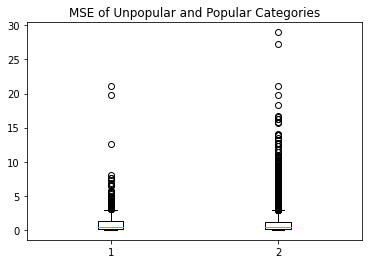

In [ ]:
plt.title("MSE of Unpopular and Popular Categories")
unpopular = test_df_fewer['mse']
popular = test_df_more['mse']
plt.boxplot([unpopular, popular])
plt.show()

Overall, the MSE of ratings in the unpopular movie categories is slightly higher than that in the popular movie categories, probably because the user latent parameter trained based on fewer ratings in the unpopular categoreis are less reliable. 

However, the variance of the MSE of ratings in the popular movie categories are larger thann that in the unpopular movie categories. A possible explanation is that a user's preferences for movies in a niche category are believed to be similar, but the preferences of the user for movies in popular categories can vary a lot more.

## Result and Limitation

The main question that this model is answering is that a user's preference of movies can vary by genres, so the user latents for different genres can be different.

The way to split the training and testing sets is the same as that in the basline model, so the training data is still the first 80000 observations, and the testing data is the last 10000 observations. Therefore, the spliting predicts behavior of a random existing user after the training data was gathered. 

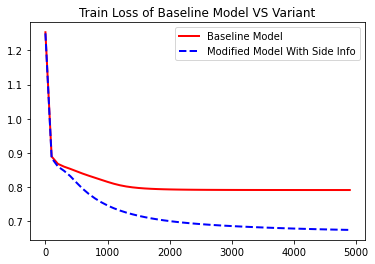

In [ ]:
plt.plot(iterations, train_loss_lst, marker='', color='red', linewidth=2, label="Baseline Model")
plt.plot(iterations, train_loss_lst1, marker='', color='blue', linewidth=2, linestyle='dashed', label="Modified Model With Side Info")
plt.title("Train Loss of Baseline Model VS Variant")
plt.legend()
plt.show()

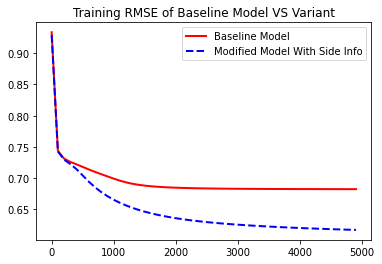

In [ ]:
plt.plot(iterations, train_rmse_lst, marker='', color='red', linewidth=2, label="Baseline Model")
plt.plot(iterations, train_rmse_lst1, marker='', color='blue', linewidth=2, linestyle='dashed', label="Modified Model With Side Info")
plt.title("Training RMSE of Baseline Model VS Variant")
plt.legend()
plt.show()

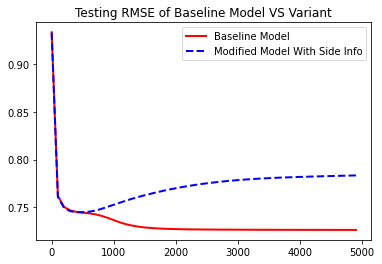

In [ ]:
plt.plot(iterations, test_rmse_lst, marker='', color='red', linewidth=2, label="Baseline Model")
plt.plot(iterations, test_rmse_lst1, marker='', color='blue', linewidth=2, linestyle='dashed', label="Modified Model With Side Info")
plt.title("Testing RMSE of Baseline Model VS Variant")
plt.legend()

From the above three curves, this variant model has 11.68% lower training loss and 6.53% lower training RMSE than the baseline model. However, this model has 5.69% higher testing RMSE than the baseline model, probably because the user latents of each genre are trained from ratings in the training sets and is able to capture the features of the preferences of the existing behaviors better.

Moreover, since there are more parameters (user_latents) in this variant, the bias of the model decreases, but as a trade-off, the variance of the model increases. Therefore, the model works better for the training set, but worse for the testing data.

# Variant 3: Non-linear Prediction Function

In the original PMF, we used a linear factorization of a user-item matrix. And by using the linear prediction function, we assumed that user's preference is consistent over all the movies. However, in reality, user's ratings are far more complicated. And their preference may change for different items. For example, a user's interest in history decumentaries may not be correlated with their interest in romantic comedies. 

And in this variant, we make a combination between global preference and specific taste. First, we model each user with T latent vectors, and all of them correspond to a single latent variable of the item. In addition, since some users have not rated many movies, they have not provided enough information about their T different tastes, so we also use the original PMF as our 'global preference'.

$r_{ui} = P_uQ_i^T+max_{t=1,...,T}W_{ut}Y_{i}^T$, 

where $r_{ui}$ is the rating of User $u$ to Item $i$, and $P$ is user latent factor matrix with dimension $n \times k$, $Q$ is item latent factor matrix with dimension $m \times k$ (the same as the baseline PMF). And $W$ ($n \times k \times T$) is the user latent factor matrix representing $T$ specific tastes of the user. And $Y (m \times k)$ is the item latent factor matrix for taste-specific component.

Every time, the specific taste among $T$ different tastes that matches best is captured using max. And this model is first introduced by Santosh Kabbur and George Karypis.

## Model and Sanity Check

Number of iterations, training loss, training RMSE, testing RMSE using Variant 3.

In [ ]:
# Model implementation in JAX (https://github.com/google/jax)
from jax.scipy.special import logsumexp

# Optimization hyperparameters
step_size = 10.0
train_iters = 5000

# Model hyperparameters
num_factors = 1
init_scale = 0.001
latent_param_regularization = 0.1

num_prob = 4 # T: number of different tastes of an item latent

train_loss_lst2 = []
train_rmse_lst2 = []
test_rmse_lst2 = []

# Init parameters.  Add an extra column for biases.
np.random.seed(2)
user_latents  = np.random.randn(num_users, num_factors + 1) * init_scale
movie_latents = np.random.randn(num_items, num_factors + 1) * init_scale
user_latents_tensor = np.random.randn(num_users, num_factors, num_prob) * init_scale # W (dimension is n*k*T)
item_latents_tensor = np.random.randn(num_items, num_factors) * init_scale # Y (dimension is m*k)
params = (user_latents, movie_latents, user_latents_tensor, item_latents_tensor)

# Actual model
mean_rating = jnp.mean(train_targets)
def pmf_predict(user_latents, movie_latents, user_latents_tensor, item_latents_tensor, inputs):
  (user_index, movie_index) = (inputs[:, 0], inputs[:, 1])
  interest = user_latents_tensor[user_index, :, 0]* item_latents_tensor[movie_index, :]
  # iterate T tastes to get the max WY
  for t in range(1, num_prob):   
    num_prob_interest =  user_latents_tensor[user_index, :, t]* item_latents_tensor[movie_index, :]
    interest = jnp.concatenate([interest, num_prob_interest], axis=1)
  max_interest = jnp.max(interest, axis=1)
  raw_preds = jnp.sum(user_latents[user_index, :-1] * movie_latents[movie_index, :-1], axis=1) \
        + mean_rating + user_latents[user_index, -1] + movie_latents[movie_index,-1] + max_interest
  return raw_preds

def regularization_loss(user_latents, movie_latents, user_latents_tensor, item_latents_tensor):
  return latent_param_regularization * (jnp.mean((user_latents)**2) + jnp.mean((movie_latents)**2 + jnp.mean((user_latents_tensor)**2)) + jnp.mean((item_latents_tensor)**2))

def prediction_mse(params, inputs, targets):
  preds = pmf_predict(*params, inputs)
  return (preds - targets)**2

def training_loss(params, inputs, targets):
  return regularization_loss(*params) + jnp.mean(prediction_mse(params, inputs, targets), axis=0)

# One training step
@jit  # Pre-compiles the function to speed up training.
def sgd_update(params, i):  # Stochastic gradient descent
  (grads_user, grads_movie, grads_user_interest, grads_movie_interest) = grad(training_loss)(params, train_inputs, train_targets) #???
  (user_latents, movie_latents, user_latents_tensor, item_latents_tensor) = params
  return (user_latents  - step_size * grads_user,  # one step of gradient descent
          movie_latents - step_size * grads_movie,
          user_latents_tensor  - step_size * grads_user_interest,
          item_latents_tensor - step_size * grads_movie_interest)

# Main training loop
for i in range(train_iters):
  params = sgd_update(params, i)
  if i % 100 == 0:
    # Print current progress
    train_loss = training_loss(params, train_inputs, train_targets)
    train_rmse = jnp.sqrt(prediction_mse(params, train_inputs, train_targets))
    test_rmse  = jnp.sqrt(prediction_mse(params, test_inputs, test_targets))
    print(i, train_loss, jnp.mean(train_rmse), jnp.mean(test_rmse))
    train_loss_lst2.append(train_loss)
    train_rmse_lst2.append(jnp.mean(train_rmse))
    test_rmse_lst2.append(jnp.mean(test_rmse))


0 1.2343854 0.93208003 0.9366645
100 0.88863605 0.7438401 0.7619097
200 0.8686982 0.73215383 0.7503606
300 0.8625818 0.727997 0.7467962
400 0.86002976 0.72600085 0.745431
500 0.8587565 0.7248884 0.7448065
600 0.8580301 0.7241873 0.7444928
700 0.8575417 0.7236973 0.74431115
800 0.857055 0.7232773 0.74418837
900 0.85607475 0.7226706 0.7440444
1000 0.85311055 0.7211411 0.74365246
1100 0.84544426 0.7171823 0.74244016
1200 0.83398724 0.7107973 0.74012834
1300 0.82297444 0.70442355 0.73716366
1400 0.81367975 0.699074 0.7340645
1500 0.8062264 0.69470954 0.7315213
1600 0.7999942 0.6909732 0.7297527
1700 0.7941514 0.6873612 0.72828937
1800 0.7885131 0.683648 0.7269799
1900 0.78342354 0.6801129 0.72584295
2000 0.7790747 0.67695147 0.72502863
2100 0.7755453 0.67429817 0.72439224
2200 0.7728016 0.6721586 0.72390753
2300 0.7706677 0.67042804 0.7235
2400 0.76897836 0.6690025 0.72315556
2500 0.76761895 0.667814 0.7228974
2600 0.76651263 0.66680074 0.72268254
2700 0.76560456 0.6659327 0.722493
2800 0.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
# MSE of each observation of the testing data
test_mse = prediction_mse(params, test_inputs, test_targets)
test_df = rating_df.iloc[90000:, :]
test_df['mse'] = test_mse.tolist()

In [ ]:
# the number of movies rated by each user
user_count = rating_df[['userID', 'itemID']].groupby(['userID']).agg(['count'])
user_count.columns = ['count']
user_count['userID'] = user_count.index
user_count.reset_index(drop=True, inplace=True)

In [ ]:
test_df = pd.merge(test_df, user_count, on="userID")

In [ ]:
# get the 1st and 3rd quantile of the number of movies rated by user
user_count.describe()

,count,userID
count,943.000000,943.000000
mean,106.044539,472.000000
std,100.931743,272.364951
min,20.000000,1.000000
25%,33.000000,236.500000
50%,65.000000,472.000000
75%,148.000000,707.500000
max,737.000000,943.000000


*Table 4:* The 1st quantile of the number of movies rated by each user is 33. And the 3rd qunatile is 148.

In [ ]:
# MSE of observations rated by user who has fewer ratings
test_df_fewer = test_df[test_df['count'] < 33]
test_df_fewer['mse'].describe()

count    601.000000
mean       1.001854
std        1.423306
min        0.000025
25%        0.104906
50%        0.483414
75%        1.244918
max        8.282392
Name: mse, dtype: float64

*Table 5:* The average MSE of obervations rated by user who has fewer ratings is 0.999263.

In [ ]:
# MSE of observations rated by user who has many ratings
test_df_more = test_df[test_df['count'] > 148]
test_df_more['mse'].describe()

count    5.492000e+03
mean     8.087439e-01
std      1.291184e+00
min      3.476389e-07
25%      6.938999e-02
50%      3.333637e-01
75%      9.866654e-01
max      1.547717e+01
Name: mse, dtype: float64

*Table 6:* The average MSE of obervations rated by user who has many ratings is 0.8154928.

However, since for both 'global preference' and 'specific taste', we need many data to discover user's latent and their different tastes. So we would expect that users with fewer ratings would have perform worse than users with many ratings. 

And this is proved. The average MSE of predictions among users who have watched less than 33 (first quantile of all 943 users) is around 1. And the average MSE of predictions among users who have watched more than 148 (third quantile of all 943 users) is around 0.815. And first quantile, median, third quantile of MSE among users who have rated many movies are all smaller than that among users who have rated fewer movies.

## Result and Limitation

The main problem that this variant has solved is that user's preference is not consistent over all the movies, and 'a user's interest in history decumentaries may have little correlation with their interest in romantic comedies'.

And we did not change the way to split training and testing data in this variant. So the training data is still the first 80000 observations, and the testing data is the last 10000 observations. So it predicts behavior of a random existing user after the training data was gathered. 

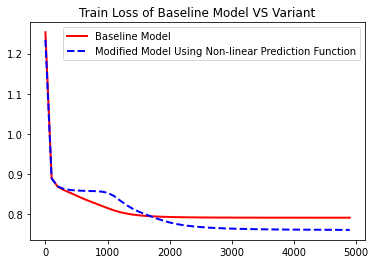

In [ ]:
plt.plot(iterations, train_loss_lst, marker='', color='red', linewidth=2, label="Baseline Model")
plt.plot(iterations, train_loss_lst2, marker='', color='blue', linewidth=2, linestyle='dashed', label="Modified Model Using Non-linear Prediction Function")
plt.title("Train Loss of Baseline Model VS Variant")
plt.legend()
plt.show()

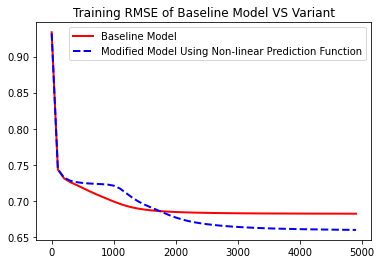

In [ ]:
plt.plot(iterations, train_rmse_lst, marker='', color='red', linewidth=2, label="Baseline Model")
plt.plot(iterations, train_rmse_lst2, marker='', color='blue', linewidth=2, linestyle='dashed', label="Modified Model Using Non-linear Prediction Function")
plt.title("Training RMSE of Baseline Model VS Variant")
plt.legend()
plt.show()

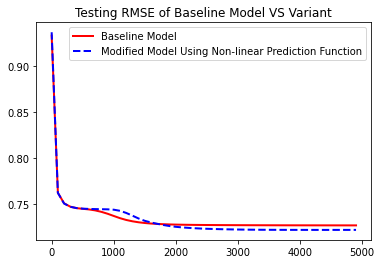

In [ ]:
plt.plot(iterations, test_rmse_lst, marker='', color='red', linewidth=2, label="Baseline Model")
plt.plot(iterations, test_rmse_lst2, marker='', color='blue', linewidth=2, linestyle='dashed', label="Modified Model Using Non-linear Prediction Function")
plt.title("Testing RMSE of Baseline Model VS Variant")
plt.legend()
plt.show()

From the above three plots, we can see that our variant has lowered training loss by 3.850%, training RMSE by 3.294%, and testing RMSE by 0.675% than the simple PMF.

However, since our variant also needs many data to train and learn users' latents. In addition, it also assumes that user has many tastes. So if many new users joining, the accuracy will be lower. Besides, if many users only rate few movies, the accuracy will be lower too. But if many users stick around and rate more movies, the accuracy will increase over time.
